In [5]:
import zipfile

with zipfile.ZipFile('Models.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')


In [6]:
import tf2onnx
import tensorflow as tf
from keras.config import enable_unsafe_deserialization
enable_unsafe_deserialization()
# Load the Keras model
keras_model_path = "Models/03_handwriting_recognition/202412101123/model.keras"
model = tf.keras.models.load_model(keras_model_path, compile=False)

# Convert the Keras model to ONNX
onnx_model_path = "Models/03_handwriting_recognition/202412101123/model.onnx"
spec = (tf.TensorSpec((None, 32, 128, 3), tf.float32, name="input"),)
onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13)

# Save the ONNX model
with open(onnx_model_path, "wb") as f:
    f.write(onnx_model.SerializeToString())

print(f"Model converted and saved at: {onnx_model_path}")


Model converted and saved at: Models/03_handwriting_recognition/202412101123/model.onnx


In [1]:
pip install mltu

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 79.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 88.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.3 MB/s eta 0:00:00
  Created wheel

In [2]:
pip install tf2onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.5
    Uninstalling protobuf-4.25.5:
      Successfully uninstalled protobuf-4.25.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.62.3 requires protobuf>=4.21.6, but you have protobuf 3.20.3 which is incompatible.


In [ ]:
import tensorflow as tf
try: [tf.config.experimental.set_memory_growth(gpu, True) for gpu in tf.config.experimental.list_physical_devices("GPU")]
except: pass

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

from mltu.preprocessors import ImageReader
from mltu.transformers import ImageResizer, LabelIndexer, LabelPadding, ImageShowCV2
from mltu.augmentors import RandomBrightness, RandomRotate, RandomErodeDilate, RandomSharpen
from mltu.annotations.images import CVImage

from mltu.tensorflow.dataProvider import DataProvider
from mltu.tensorflow.losses import CTCloss
from mltu.tensorflow.callbacks import Model2onnx, TrainLogger
from mltu.tensorflow.metrics import CWERMetric

from model import train_model
from configs import ModelConfigs

import os
import tarfile
from tqdm import tqdm
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile


def download_and_unzip(url, extract_to="Datasets", chunk_size=1024*1024):
    http_response = urlopen(url)

    data = b""
    iterations = http_response.length // chunk_size + 1
    for _ in tqdm(range(iterations)):
        data += http_response.read(chunk_size)

    zipfile = ZipFile(BytesIO(data))
    zipfile.extractall(path=extract_to)

dataset_path = os.path.join("Datasets", "IAM_Words")
if not os.path.exists(dataset_path):
    download_and_unzip("https://git.io/J0fjL", extract_to="Datasets")

    file = tarfile.open(os.path.join(dataset_path, "words.tgz"))
    file.extractall(os.path.join(dataset_path, "words"))

dataset, vocab, max_len = [], set(), 0

# Preprocess the dataset by the specific IAM_Words dataset file structure
words = open(os.path.join(dataset_path, "words.txt"), "r").readlines()
for line in tqdm(words):
    if line.startswith("#"):
        continue

    line_split = line.split(" ")
    if line_split[1] == "err":
        continue

    folder1 = line_split[0][:3]
    folder2 = "-".join(line_split[0].split("-")[:2])
    file_name = line_split[0] + ".png"
    label = line_split[-1].rstrip("\n")

    rel_path = os.path.join(dataset_path, "words", folder1, folder2, file_name)
    if not os.path.exists(rel_path):
        print(f"File not found: {rel_path}")
        continue

    dataset.append([rel_path, label])
    vocab.update(list(label))
    max_len = max(max_len, len(label))

# Create a ModelConfigs object to store model configurations
configs = ModelConfigs()

# Save vocab and maximum text length to configs
configs.vocab = "".join(vocab)
configs.max_text_length = max_len
configs.save()

# Create a data provider for the dataset
data_provider = DataProvider(
    dataset=dataset,
    skip_validation=True,
    batch_size=configs.batch_size,
    data_preprocessors=[ImageReader(CVImage)],
    transformers=[
        ImageResizer(configs.width, configs.height, keep_aspect_ratio=False),
        LabelIndexer(configs.vocab),
        LabelPadding(max_word_length=configs.max_text_length, padding_value=len(configs.vocab)),
        ],
)

# Split the dataset into training and validation sets
train_data_provider, val_data_provider = data_provider.split(split = 0.9)

# Augment training data with random brightness, rotation and erode/dilate
train_data_provider.augmentors = [
    RandomBrightness(),
    RandomErodeDilate(),
    RandomSharpen(),
    RandomRotate(angle=10),
    ]

# Creating TensorFlow model architecture
model = train_model(
    input_dim = (configs.height, configs.width, 3),
    output_dim = len(configs.vocab),
)

# Compile the model and print summary
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=configs.learning_rate),
    loss=CTCloss(),
    metrics=[CWERMetric(padding_token=len(configs.vocab))],
)
model.summary(line_length=110)

# Define callbacks
earlystopper = EarlyStopping(monitor="val_CER", patience=20, verbose=1)
checkpoint = ModelCheckpoint(f"{configs.model_path}/model.keras", monitor="val_CER", verbose=1, save_best_only=True, mode="min")
trainLogger = TrainLogger(configs.model_path)
tb_callback = TensorBoard(f"{configs.model_path}/logs", update_freq=1)
reduceLROnPlat = ReduceLROnPlateau(monitor="val_CER", factor=0.9, min_delta=1e-10, patience=10, verbose=1, mode="auto")
model2onnx = Model2onnx(f"{configs.model_path}/model.keras")
earlystopper = EarlyStopping(monitor="val_CER", patience=20, verbose=1, mode='min')

# Train the model
model.fit(
    train_data_provider,
    validation_data=val_data_provider,
    epochs=150,
    callbacks=[earlystopper, checkpoint, trainLogger, reduceLROnPlat, tb_callback, model2onnx],

)

# Save training and validation datasets as csv files
train_data_provider.to_csv(os.path.join(configs.model_path, "train.csv"))
val_data_provider.to_csv(os.path.join(configs.model_path, "val.csv"))
import tensorflow as tf

#import tensorflow as tf

# Configure TensorFlow to use GPU
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            # Set GPU to allocate all memory
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)],
            )
        print(f"Using GPU: {gpus}")
    except RuntimeError as e:
        print(f"Error configuring GPU: {e}")
else:
    print("No GPU detected. Using CPU.")



100%|██████████| 115338/115338 [00:01<00:00, 109767.26it/s]
INFO:DataProvider:Skipping Dataset validation...
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                   ┃ Output Shape              ┃          Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)             │ (None, 32, 128, 3)        │                0 │ -                          │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ lambda (Lambda)                │ (None, 32, 128, 3)        │                0 │ input[0][0]                │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ conv2d (Conv2D)                │ (None, 32, 128, 16)       │              448 │ lambda[0][0]               │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ batch_normalization            │ (None, 32, 128, 16)       │               64 │ conv2d[0][0]               │
│ (BatchNormalization)           │                           │                  │                            │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ leaky_re_lu (LeakyReLU)        │ (None, 32, 128, 16)       │                0 │ batch_normalization[0][0]  │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)              │ (None, 32, 128, 16)       │            2,320 │ leaky_re_lu[0][0]          │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ batch_normalization_1          │ (None, 32, 128, 16)       │               64 │ conv2d_1[0][0]             │
│ (BatchNormalization)           │                           │                  │                            │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)              │ (None, 32, 128, 16)       │               64 │ lambda[0][0]               │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ add (Add)                      │ (None, 32, 128, 16)       │                0 │ batch_normalization_1[0][… │
│                                │                           │                  │ conv2d_2[0][0]             │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU)      │ (None, 32, 128, 16)       │                0 │ add[0][0]                  │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ dropout (Dropout)              │ (None, 32, 128, 16)       │                0 │ leaky_re_lu_1[0][0]        │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)              │ (None, 16, 64, 16)        │            2,320 │ dropout[0][0]              │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ batch_normalization_2          │ (None, 16, 64, 16)        │               64 │ conv2d_3[0][0]             │
│ (BatchNormalization)           │                           │                  │                            │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU)      │ (None, 16, 64, 16)        │                0 │ batch_normalization_2[0][… │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)              │ (None, 16, 64, 16)        │            2,320 │ leaky_re_lu_2[0][0]        │
├───

 Total params: 549,455 (2.10 MB)

 Trainable params: 547,983 (2.09 MB)

 Non-trainable params: 1,472 (5.75 KB)

Epoch 1/150


KeyboardInterrupt: 

In [ ]:
pip install opencv-python-headless

--- Custom Image Input for Prediction ---
Enter the path to your image (or type 'exit' to quit): /content/Screenshot 2024-12-13 at 16.52.01.png
Prediction for /content/Screenshot 2024-12-13 at 16.52.01.png: b..


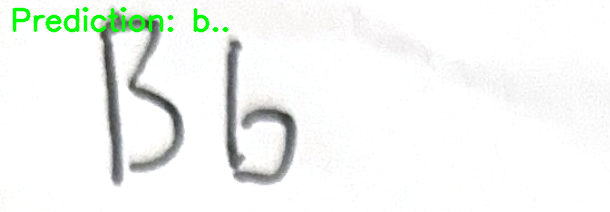

Enter the path to your image (or type 'exit' to quit): /content/Screenshot 2024-12-13 at 16.53.05.png
Prediction for /content/Screenshot 2024-12-13 at 16.53.05.png: .


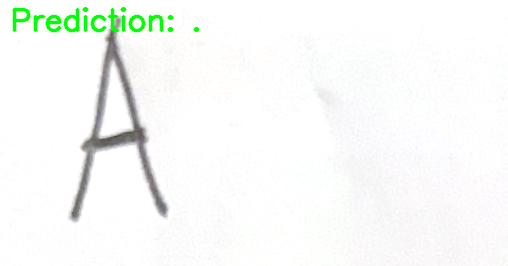

Enter the path to your image (or type 'exit' to quit): /content/Screenshot 2024-12-13 at 16.53.48.png
Prediction for /content/Screenshot 2024-12-13 at 16.53.48.png: lif-


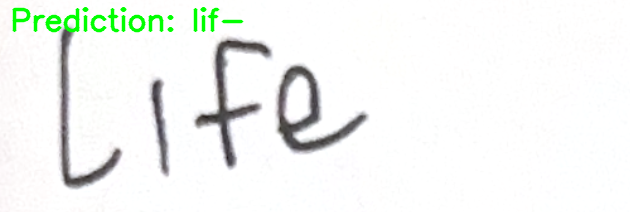

Enter the path to your image (or type 'exit' to quit): /content/Screenshot 2024-12-13 at 16.54.50.png
Prediction for /content/Screenshot 2024-12-13 at 16.54.50.png: Move


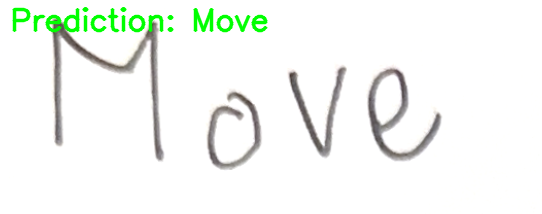

KeyboardInterrupt: Interrupted by user

In [70]:
import cv2
import typing
import numpy as np

from mltu.inferenceModel import OnnxInferenceModel
from mltu.utils.text_utils import ctc_decoder, get_cer
from google.colab.patches import cv2_imshow  # Import cv2_imshow for Colab compatibility

class ImageToWordModel(OnnxInferenceModel):
    def __init__(self, char_list: typing.Union[str, list], *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.char_list = char_list
        # Access input shape and input name after model loading
        self.input_shape = self.model.get_inputs()[0].shape
        self.input_name = self.model.get_inputs()[0].name  # Get input name

    def predict(self, image: np.ndarray):
        # Resize the image to match the model's input shape
        image = cv2.resize(image, self.input_shape[1:3][::-1])

        image_pred = np.expand_dims(image, axis=0).astype(np.float32)

        preds = self.model.run(None, {self.input_name: image_pred})[0]

        text = ctc_decoder(preds, self.char_list)[0]

        return text

if __name__ == "__main__":
    from mltu.configs import BaseModelConfigs

    configs = BaseModelConfigs.load("Models/03_handwriting_recognition/202412101123/configs.yaml")

    # Update model_path to point to the .onnx file
    model = ImageToWordModel(
        model_path="Models/03_handwriting_recognition/202412101123/model.onnx",
        char_list=configs.vocab
    )

    print("--- Custom Image Input for Prediction ---")
    while True:
        # Ask the user to provide an image path
        image_path = input("Enter the path to your image (or type 'exit' to quit): ")
        if image_path.lower() == 'exit':
            print("Exiting the program.")
            break

        try:
            # Load the image
            image = cv2.imread(image_path)
            if image is None:
                print(f"Error: Could not read the image at {image_path}. Please try again.")
                continue

            # Predict the text from the image
            prediction_text = model.predict(image)

            # Display the prediction
            print(f"Prediction for {image_path}: {prediction_text}")

            # Optionally, display the image with prediction
            annotated_image = image.copy()
            cv2.putText(
                annotated_image,
                f"Prediction: {prediction_text}",
                (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,
                (0, 255, 0),
                2,
                cv2.LINE_AA,
            )
            # Replace cv2.imshow with cv2_imshow
            cv2_imshow(annotated_image)

        except Exception as e:
            print(f"Error processing the image: {e}")


In [3]:
!pip install pdf2image==1.16.0

In [4]:
!apt-get install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.5 [186 kB]
Fetched 186 kB in 0s (946 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 123633 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.5_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.5) ...
Setting up poppler-utils (22.02.0-2ubuntu0.5) ...
Processing triggers for man-db (2.10.2-1) ...


In [54]:


from pdf2image import convert_from_path

def convert_pdf_to_png(pdf_path, output_folder):
  """Converts a PDF file to PNG images.

  Args:
    pdf_path: Path to the PDF file.
    output_folder: Path to the folder where PNG images will be saved.
  """
  # Convert the PDF to a list of PIL Image objects
  images = convert_from_path(pdf_path)

  # Save each image as a PNG file
  for i, image in enumerate(images):
    image.save(f"{output_folder}/page_{i + 1}.png", "PNG")

  print(f"PDF converted to PNG images and saved in: {output_folder}")

# Example usage
pdf_path = "/content/Scanned Documents(2).pdf"  # Replace with your PDF file path
output_folder = "/content"  # Replace with your desired output folder

convert_pdf_to_png(pdf_path, output_folder)

PDF converted to PNG images and saved in: /content


In [59]:
import cv2

def crop_image(image_path, output_path):
  """Crops an image to 350x150 pixels from the top-left corner.

  Args:
    image_path: Path to the input image.
    output_path: Path to save the cropped image.
  """
  img = cv2.imread(image_path)
  cropped_img = img[0:700, 0:2000]  # Crop from top-left corner
  cv2.imwrite(output_path, cropped_img)
  print(f"Cropped image saved to: {output_path}")

# Example usage:
input_image_path = "/content/page_1.png"  # Replace with your image path
output_image_path = "/content/cropped_image.jpg"  # Replace with desired output path
crop_image(input_image_path, output_image_path)

Cropped image saved to: /content/cropped_image.jpg


Enter the path to your PDF file: /content/Scanned Documents(1).pdf
PDF converted to PNG images and saved in: output_images
Cropped image saved to: output_images/cropped/cropped_page_1.png
--- Predictions ---
Prediction for output_images/cropped/cropped_page_1.png: Move


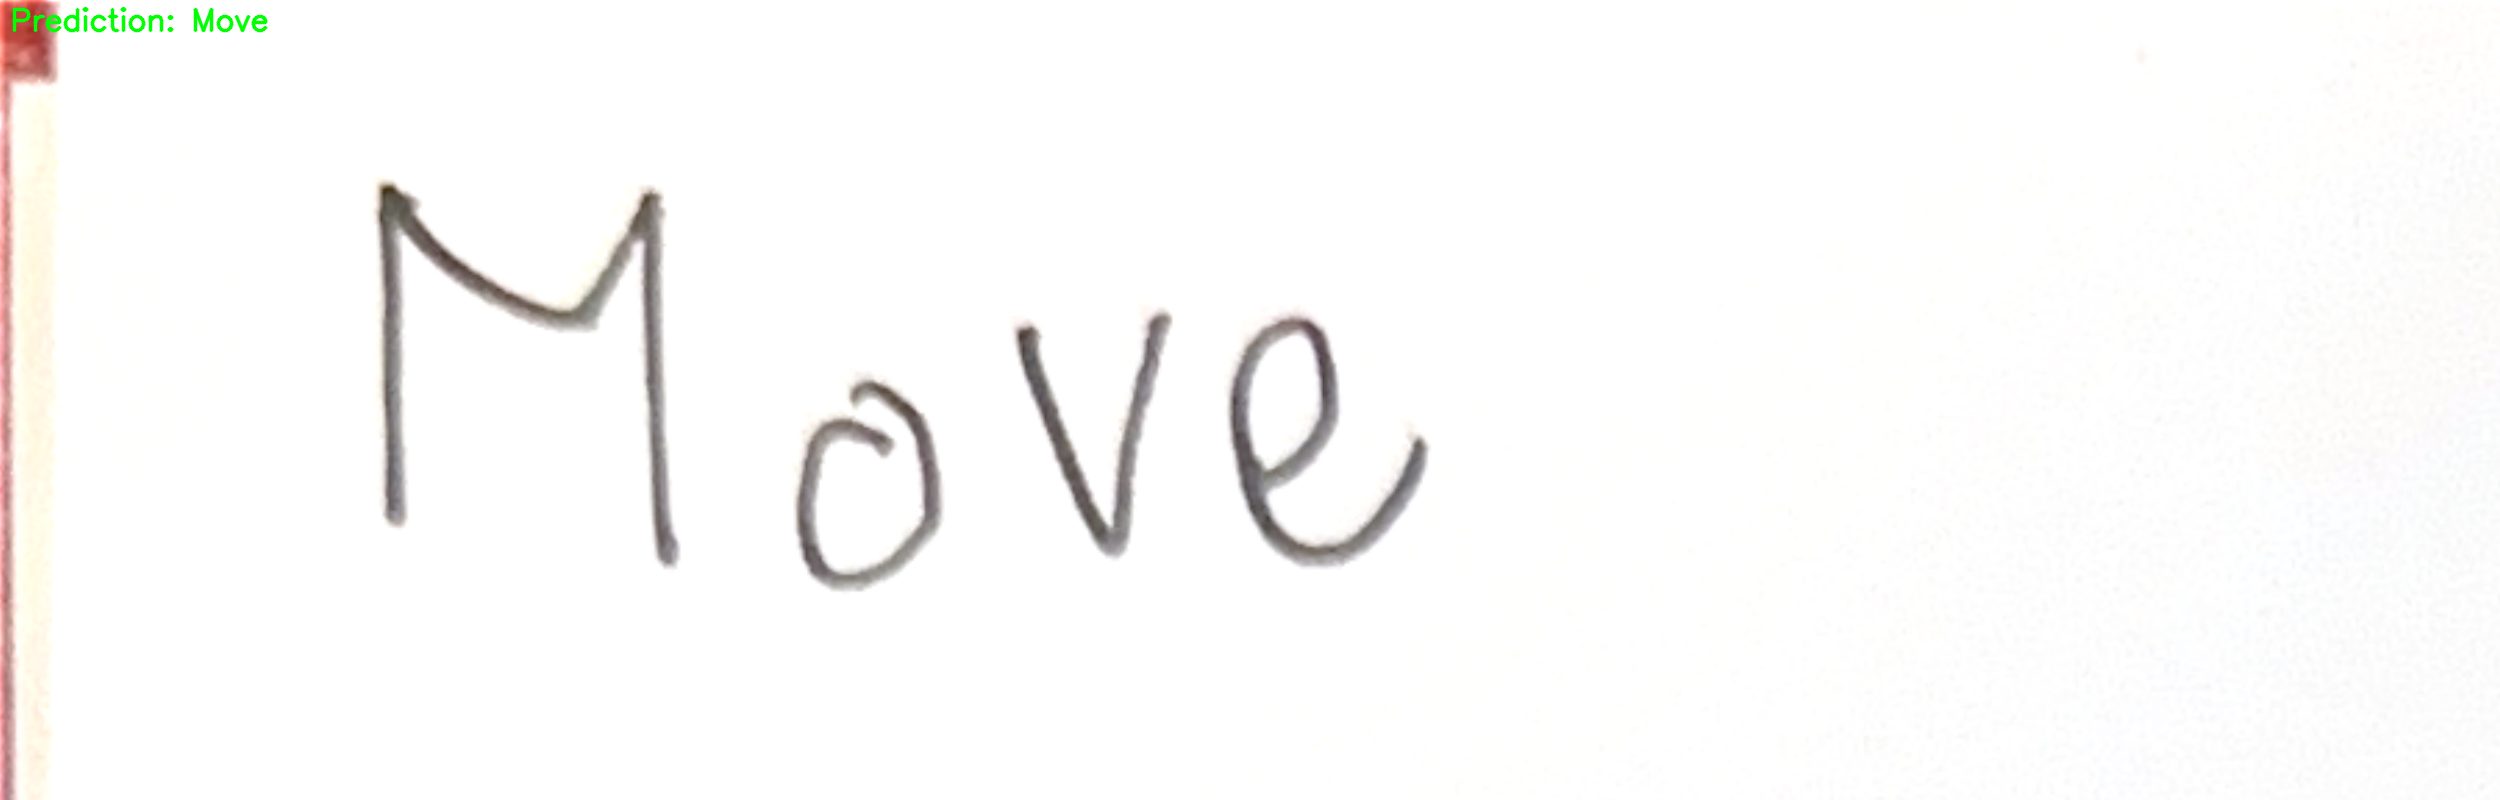

In [15]:
import os
import cv2
import typing
import numpy as np
from pdf2image import convert_from_path
from mltu.inferenceModel import OnnxInferenceModel
from mltu.utils.text_utils import ctc_decoder
from google.colab.patches import cv2_imshow  # For Colab compatibility

def crop_image(image_path, output_path, crop_dims=(800, 2500)):
    """Crops an image to specified dimensions from the top-left corner.

    Args:
        image_path: Path to the input image.
        output_path: Path to save the cropped image.
        crop_dims: Tuple specifying the crop dimensions (height, width).
    """
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image not found at {image_path}")

    cropped_img = img[0:crop_dims[0], 0:crop_dims[1]]
    cv2.imwrite(output_path, cropped_img)
    print(f"Cropped image saved to: {output_path}")

def convert_pdf_to_png(pdf_path, output_folder):
    """Converts a PDF file to PNG images.

    Args:
        pdf_path: Path to the PDF file.
        output_folder: Path to the folder where PNG images will be saved.
    """
    images = convert_from_path(pdf_path)

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for i, image in enumerate(images):
        image.save(f"{output_folder}/page_{i + 1}.png", "PNG")

    print(f"PDF converted to PNG images and saved in: {output_folder}")

class ImageToWordModel(OnnxInferenceModel):
    def __init__(self, char_list: typing.Union[str, list], *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.char_list = char_list
        self.input_shape = self.model.get_inputs()[0].shape
        self.input_name = self.model.get_inputs()[0].name

    def predict(self, image: np.ndarray):
        image = cv2.resize(image, self.input_shape[1:3][::-1])
        image_pred = np.expand_dims(image, axis=0).astype(np.float32)
        preds = self.model.run(None, {self.input_name: image_pred})[0]
        text = ctc_decoder(preds, self.char_list)[0]
        return text

def main():
    # Get user input for the PDF path
    pdf_path = input("Enter the path to your PDF file: ").strip()

    # Fixed output folder, model path, and configs path
    output_folder = "output_images"
    model_path = "Models/03_handwriting_recognition/202412101123/model.onnx"
    configs_path = "Models/03_handwriting_recognition/202412101123/configs.yaml"

    # Step 1: Convert PDF to PNG
    convert_pdf_to_png(pdf_path, output_folder)

    # Step 2: Crop Images
    cropped_folder = f"{output_folder}/cropped"
    if not os.path.exists(cropped_folder):
        os.makedirs(cropped_folder)

    for file_name in os.listdir(output_folder):
        if file_name.endswith(".png"):
            input_image_path = os.path.join(output_folder, file_name)
            output_image_path = os.path.join(cropped_folder, f"cropped_{file_name}")
            crop_image(input_image_path, output_image_path)

    # Step 3: Handwriting Recognition
    from mltu.configs import BaseModelConfigs

    configs = BaseModelConfigs.load(configs_path)
    model = ImageToWordModel(
        model_path=model_path,
        char_list=configs.vocab
    )

    print("--- Predictions ---")
    for file_name in os.listdir(cropped_folder):
        if file_name.endswith(".png"):
            image_path = os.path.join(cropped_folder, file_name)
            image = cv2.imread(image_path)
            if image is None:
                print(f"Error: Could not read the image at {image_path}.")
                continue

            prediction_text = model.predict(image)
            print(f"Prediction for {image_path}: {prediction_text}")

            annotated_image = image.copy()
            cv2.putText(
                annotated_image,
                f"Prediction: {prediction_text}",
                (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,
                (0, 255, 0),
                2,
                cv2.LINE_AA,
            )
            cv2_imshow(annotated_image)

if __name__ == "__main__":
    main()


In [13]:
import tkinter as tk
from tkinter import filedialog

def drag_and_drop_file():
    """Opens a file dialog to allow drag-and-drop file selection."""
    # Create a Tkinter root window and hide it
    root = tk.Tk()
    root.withdraw()

    # Open a file dialog
    file_path = filedialog.askopenfilename(title="Select a File", filetypes=[("All files", "*.*")])

    if file_path:
        print(f"File selected: {file_path}")
    else:
        print("No file selected.")

if __name__ == "__main__":
    drag_and_drop_file()


TclError: no display name and no $DISPLAY environment variable

In [12]:
pip install tkinter


ERROR: Could not find a version that satisfies the requirement tkinter (from versions: none)
ERROR: No matching distribution found for tkinter
